In [ ]:
#sankey plot of the level 1 and level 2 identifications for expsoure patterns

In [107]:
## ##output dataframe
import pandas as pd
import numpy as np
import tabulate
postarget8 = pd.read_csv('D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Pos_AlignmentResults/library_search_res_pos_level1andlevel2.csv')
negtarget8 = pd.read_csv('D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/library_search_res_neg_level1andlevel2.csv')

#subset both pos and neg with annotational_level 1, 2a and 2b
poslevel2 = postarget8.copy()
neglevel2 = negtarget8.copy()


#extract column starts with 'BH' and 'feature_id'
poslevel2copy = poslevel2.copy()
poslevel2copy = poslevel2copy.loc[:, poslevel2.columns.str.startswith('BH')].astype(float).fillna(0)
#calculate the detection frequency for each row
poslevel2['detection_frequency'] = poslevel2copy.loc[:, :].apply(lambda x: (x >= 5000).sum() / len(x) * 100, axis=1)
poslevel2['polarity'] = 'pos'

neglevel2copy = neglevel2.copy()
neglevel2copy = neglevel2copy.loc[:, neglevel2.columns.str.startswith('BH')].astype(float).fillna(0)
#calculate the detection frequency for each row
neglevel2['detection_frequency'] = neglevel2copy.loc[:, :].apply(lambda x: (x >= 5000).sum() / len(x) * 100, axis=1)
neglevel2['polarity'] = 'neg'

#combine pos and neg level2 identifications
level2 = pd.concat([poslevel2, neglevel2], axis=0, ignore_index=True)
level2_info = level2.copy()
level2 = level2[['feature_id', 'polarity', 'detection_frequency', 'annotation_level', 'DTXSID']]

#remove duplicated row with DTXSID and polarity
level2 = level2.drop_duplicates(subset=['DTXSID', 'polarity'], keep='first')

##remove duplicated row with DTXSID and retain the row with highest detection frequency
level2 = level2.sort_values(by='detection_frequency', ascending=False).drop_duplicates(subset=['DTXSID'], keep='first')

#drop column starts with 'BH'
level2 = level2.drop(level2.columns[level2.columns.str.startswith('BH')], axis=1)

#merge industrial information
level2copy = level2.copy()
targetmz_path = ["D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/plastic_map_chemlist/Plastic_Chemical_withRT_CFMID_spectrumdatabase_chemical_annotation_20250404.csv"] #plastic chemical list with predicted/library RT, CRMID, and spectrum ID match record,
plastics_chem = pd.read_csv(targetmz_path[0])
level2copy = pd.merge(level2copy, plastics_chem, how='left', left_on='DTXSID', right_on='DTXSID')

#replace emtpy string or cell with NaN 
level2copy = level2copy.replace(r'^\s*$', np.nan, regex=True)

#make new column name Polymer_label: if column value in Polymer is blank or null value, Polymer_label = 'unknown', if column value in Polymer is not blank and cotain ',', polymer_label = 'Multiple polymers', if column value in Polymer is not blank and not contain ',', polymer_label = polymer value
level2copy['Polymer_label'] = level2copy['Polymer'].apply(lambda x: 'Unknown_Poly' if pd.isna(x) else ('Mltiple_Poly' if ',' in x else x))

# #make new column as Function_label: if column value in Function is blank, Function_label = 'unknown', if column value in Function is not blank and cotain ',', Function_label = 'Multiple functions', if column value in Function is not blank and not contain ',', Function_label = function value
level2copy['Function_label'] = level2copy['Function'].apply(lambda x: 'Unknown_Func' if pd.isna(x) else ('Multiple_Func' if ',' in x else x))

# #convert production column to numeric, and fill blank with 0
level2copy['Total_production'] = pd.to_numeric(level2copy['Total_production'], errors='coerce').fillna(0)
# #make new column as Production_label: if column value in Production is blank, Production_label = 'unknown', if column value in Production >=1000, Production_label = 'High', if column value in Production <1000 and >=100, Production_label = 'mid', if column value in Production <100 and is not blank, Production_label = 'low', if column value  in production = 0, production_label = 'unknown_PV'
level2copy['Production_label'] = level2copy['Total_production'].apply(lambda x: 'Unknown_PV' if (x == 0) else ('High_PV' if x >= 1000 else ('Mid_PV' if x >= 100 else 'Low_PV')))

# #make detecton frequency label as 'high' if detection frequency >= 70, 'mid' if detection frequency < 70 and >= 30, 'low' if detection frequency < 30 and is not blank
level2copy['detection_frequency_label'] = level2copy['detection_frequency'].apply(lambda x: 'High_DF' if x >= 65 else ('Mid_DF' if x >= 30 else 'Low_DF'))

#import the classifier structural classification and merge
structure_classification = pd.read_csv('D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/classyfire_20250501004832.csv')

#merge Class column from structure_classification to level2copy based on INCHIKEY
level2copy = pd.merge(level2copy, structure_classification[['INCHIKEY', 'Superclass']], how='left', left_on='INCHIKEY', right_on='INCHIKEY')

#subset column of level2copy
level2copy = level2copy[['feature_id', 'PREFERRED_NAME','polarity', 'DTXSID','INCHIKEY', 'annotation_level', 'Polymer_label', 'Function_label', 'Production_label', 'detection_frequency_label', 'Superclass']]

#take a look into the string value in Superclass column,
    ## if the string contains compounds, replace the 'compounds' with 'cmp', loop thorugh each row value
for iter, row in level2copy.iterrows():
    classtr = row['Superclass']
    if 'compounds' in classtr:
        level2copy.at[iter, 'Superclass'] = classtr.replace('compounds', 'cmp')
    if 'Lipids and lipid-like molecules' in classtr:
        level2copy.at[iter, 'Superclass'] = classtr.replace('Lipids and lipid-like molecules', 'lipid-like mols')
    
    polymer = row['Polymer_label']
    
    if " - " in polymer:
        level2copy.at[iter,'Polymer_label'] = polymer.replace(' - ', '_')

# print(summary(level2copy))
print(level2copy['Superclass'].unique())
print(level2copy['Polymer_label'].unique())

level2copy.to_csv('D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/library_search_res_pos_level1andlevel2_sankyplot.csv', index=False)

['lipid-like mols' 'Organic acids and derivatives' 'Organic oxygen cmp'
 'Benzenoids' 'Organoheterocyclic cmp' 'Organic nitrogen cmp'
 'Phenylpropanoids and polyketides' 'Hydrocarbons' 'Organophosphorus cmp'
 'Organohalogen cmp']
['Unknown_Poly' 'Mltiple_Poly' 'PET' 'Other_Thermoplastic' 'PVC' 'PUR'
 'PA' 'LDPE' 'PP' 'Other_Rubber' 'PS' 'ABS' 'Other_Bioplastic']


In [108]:
#count the number of unique DTXSID in level2copy
print("The number of unique DTXSID in level2copy is: ", len(level2_info['DTXSID'].unique()))
#select the unique DTXSID in level2_info by keep the first appearance
level2_info = level2_info.drop_duplicates(subset=['DTXSID'], keep='first')
#subtset rows with annotation_level = 2a or 2b
level2_info = level2_info[level2_info['annotation_level'].isin(['2a', '2b'])]
#subset rows with blood_check = N
level2_info = level2_info[level2_info['BloodExpo_check'] == 'N']
#print the number of unique DTXSID in level2_info
print("The number of unique DTXSID in level2_info is: ", len(level2_info['DTXSID'].unique()))

The number of unique DTXSID in level2copy is:  441
The number of unique DTXSID in level2_info is:  230


In [109]:
import pandas as pd
import plotly.graph_objects as go
from plotly.colors import qualitative

# ——— LOAD & CLEAN ———
data = level2copy.copy()

cols = [
    "annotation_level",
    "Production_label",
    "detection_frequency_label",
    "Superclass",
    "Function_label",
    "Polymer_label"
]

# Fill downstream missing with “Unknown”
for c in cols[2:]:
    data[c] = data[c].fillna("Unknown")

# Strip & stringize
for c in cols:
    data[c] = data[c].astype(str).str.strip()

# ——— BUILD UNIQUE NODE KEYS ———
node_keys = []
for col in cols:
    for val in dict.fromkeys(data[col]):
        node_keys.append((col, val))

counts = {}
for col, val in node_keys:
    counts[(col, val)] = (data[col] == val).sum()

# nodes    = list(counts.keys())
# labels   = [val for col, val in nodes]
# node_map = { (col,val): idx for idx,(col,val) in enumerate(nodes) }
# counts per (col,val)

# total rows
total = len(data)

nodes    = list(dict.fromkeys(node_keys))
labels   = [
    f"{val} ({counts[(col,val)]/total*100:.1f}%)"
    for col,val in nodes
]
node_map = { (col,val): idx for idx,(col,val) in enumerate(nodes) }

# ——— CUSTOM X POSITIONS ———
# We want a bigger gap after Superclass (index 2)
# You can tweak these 6 numbers (all between 0 and 1)
x_pos = {
    0: 0.00,   # annotation_level
    1: 0.12,   # detection_frequency_label
    2: 0.24,   # Superclass
    3: 0.36,   # Production_label  <-- moved right for extra breathing room
    4: 0.60,   # Function_label
    5: 0.92   # Polymer_label
}

# ——— POSITION NODES ———
n_cols = len(cols)
palette = qualitative.Pastel[:n_cols]

nodes_by_col = {i: [] for i in range(n_cols)}
for (col, val) in nodes:
    idx = cols.index(col)
    nodes_by_col[idx].append((col, val))

node_x, node_y, node_color = [], [], []
for idx in range(n_cols):
    group = nodes_by_col[idx]
    m     = len(group)
    for j, (col, val) in enumerate(group):
        node_x.append(x_pos[idx])
        # evenly space vertically
        node_y.append(1 - (j + 0.5) / m)
        node_color.append(palette[idx])

# ——— BUILD LINKS ———
sources, targets, values = [], [], []
for _, row in data.iterrows():
    seq = [(col, row[col]) for col in cols]
    for a, b in zip(seq, seq[1:]):
        sources.append(node_map[a])
        targets.append(node_map[b])
        values.append(1)

# ——— PLOT ———
fig = go.Figure(go.Sankey(
    # arrangement="freeform",
    arrangement = 'snap',
    node=dict(
        x=node_x,
        y=node_y,
        pad=15,
        thickness=24,
        line=dict(color="black", width=1),
        label=labels,
        color=node_color,
        align='left'
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(150,150,150,0.4)"
    )
))

fig.update_layout(
    font=dict(family='Arial Black', size=12, color='black'),
    margin=dict(l=50, r=50, t=80, b=50),
    width=1400,   # increase total width if you need more room
    height=600
)

fig.show()

In [5]:
print(level2copy.shape)

#find unique feature_id in pos and negative polarity for level 2 identifications
# pos_unique = level2copy[(level2copy['polarity'] == 'pos') &(level2copy['annotation_level']=='2')]['feature_id'].unique()
pos_feature = level2copy[(level2copy['polarity'] == 'pos')&(level2copy['annotation_level'] != '1')]['feature_id']
print("Number of unique feature_id in pos polarity: ", len(pos_feature))
# neg_unique = level2copy[(level2copy['polarity'] == 'neg') &(level2copy['annotation_level']=='2')]['feature_id'].unique()
neg_feature = level2copy[(level2copy['polarity'] == 'neg') &level2copy['annotation_level'] != '1']['feature_id']
print("Number of unique feature_id in neg polarity: ", len(neg_feature))

(441, 11)
Number of unique feature_id in pos polarity:  137
Number of unique feature_id in neg polarity:  441


In [6]:
#extract BC data from netargeted and postargeted
neg_peak_area = 'D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/Neg_PCA_batchcorrected_data.csv'  #feature id with duplicated peak abundance data 
pos_peak_area = 'D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Pos_AlignmentResults/Pos_PCA_batchcorrected_data.csv'  #feature id with duplicated peak abundance data
neg_peak_area = pd.read_csv(neg_peak_area)
pos_peak_area = pd.read_csv(pos_peak_area)

#extract the corrected peak area data for pos and neg polarity based on the feature_id
pos_peak_area_level = pos_peak_area[pos_peak_area['feature_id'].isin(pos_feature)]
neg_peak_area_level = neg_peak_area[neg_peak_area['feature_id'].isin(neg_feature)]

pos_original_feat = pos_peak_area_level['feature_id']
neg_original_feat = neg_peak_area_level['feature_id']

In [7]:
#perform correlation analysis between each feature_id in pos and neg polarity
neg_peak_area_level = neg_peak_area_level.drop(columns=['feature_id'])
pos_peak_area_level = pos_peak_area_level.drop(columns=['feature_id'])
neg_peak_area_level = neg_peak_area_level.T
pos_peak_area_level = pos_peak_area_level.T
neg_peak_area_level.columns = neg_original_feat
pos_peak_area_level.columns = pos_original_feat
neg_peak_area_level = neg_peak_area_level.reset_index()
pos_peak_area_level = pos_peak_area_level.reset_index()
neg_peak_area_level = neg_peak_area_level.rename(columns={'index': 'sample_id'})
pos_peak_area_level = pos_peak_area_level.rename(columns={'index': 'sample_id'})
neg_peak_area_level = neg_peak_area_level.set_index('sample_id')
pos_peak_area_level = pos_peak_area_level.set_index('sample_id')

#calculate the correlation by using spearman method and calculate the p value
neg_corr = neg_peak_area_level.corr(method='spearman')
pos_corr = pos_peak_area_level.corr(method='spearman')
neg_corr = neg_corr.reset_index()
pos_corr = pos_corr.reset_index()
neg_corr = neg_corr.rename(columns={'index': 'feature_id'})
pos_corr = pos_corr.rename(columns={'index': 'feature_id'})

neg_corr = neg_corr.melt(id_vars=['feature_id'], var_name='feature_id2', value_name='correlation')
pos_corr = pos_corr.melt(id_vars=['feature_id'], var_name='feature_id2', value_name='correlation')

#find rows with correlation > 0.8 and < -0.8 with p value < 0.05
# neg_corr = neg_corr[(neg_corr['correlation'] > 0.5) | (neg_corr['correlation'] < -0.5)]
# pos_corr = pos_corr[(pos_corr['correlation'] > 0.5) | (pos_corr['correlation'] < -0.5)]

In [8]:
print(pos_corr.head(10)) 

        feature_id      feature_id2  correlation
0  0.744_104.10724  0.744_104.10724     1.000000
1  8.673_105.06994  0.744_104.10724     0.783762
2  4.519_107.04924  0.744_104.10724     0.126801
3  7.945_109.10127  0.744_104.10724     0.084892
4  6.793_123.08043  0.744_104.10724     0.813875
5   6.78_130.06526  0.744_104.10724     0.459361
6   1.21_132.10181  0.744_104.10724     0.270860
7  6.663_135.08046  0.744_104.10724     0.816560
8   5.96_136.07597  0.744_104.10724     0.718443
9   1.34_137.04608  0.744_104.10724     0.358169


In [68]:
#subset the feature id by the different polymer group, function group, production group, by each polymer group, function group, and production group
neg_corr_highPV = neg_corr[neg_corr['feature_id'].isin(level2copy[level2copy['Production_label'] == 'High_PV']['feature_id'])]
neg_corr_midPV = neg_corr[neg_corr['feature_id'].isin(level2copy[level2copy['Production_label'] == 'Mid_PV']['feature_id'])]
neg_corr_lowPV = neg_corr[neg_corr['feature_id'].isin(level2copy[level2copy['Production_label'] == 'Low_PV']['feature_id'])]

pos_corr_highPV = pos_corr[pos_corr['feature_id'].isin(level2copy[level2copy['Production_label'] == 'High_PV']['feature_id'])]
pos_corr_midPV = pos_corr[pos_corr['feature_id'].isin(level2copy[level2copy['Production_label'] == 'Mid_PV']['feature_id'])]
pos_corr_lowPV = pos_corr[pos_corr['feature_id'].isin(level2copy[level2copy['Production_label'] == 'Low_PV']['feature_id'])]

#print pos and neg highPV with correlation > 0.8 and < -0.8
#remove rows with identical feature_id and feature_id2, when feature_id == feature_id2
pos_corr_highPV = pos_corr_highPV[(pos_corr_highPV['feature_id'] != pos_corr_highPV['feature_id2'])]
neg_corr_highPV = neg_corr_highPV[(neg_corr_highPV['feature_id'] != neg_corr_highPV['feature_id2'])]
#positive correlation
pos_corr_highPV = pos_corr_highPV[(pos_corr_highPV['correlation'] > 0.95) | (pos_corr_highPV['correlation'] < -0.95)]
pos_corr_highPV = pos_corr_highPV.drop_duplicates(subset=['feature_id', 'feature_id2'], keep='first')
pos_corr_highPV = pos_corr_highPV.sort_values(by='correlation', ascending=False)
pos_corr_highPV = pos_corr_highPV.reset_index(drop=True)

#negative correlation
neg_corr_highPV = neg_corr_highPV[(neg_corr_highPV['correlation'] > 0.95) | (neg_corr_highPV['correlation'] < -0.95)]
neg_corr_highPV = neg_corr_highPV.drop_duplicates(subset=['feature_id', 'feature_id2'], keep='first')
neg_corr_highPV = neg_corr_highPV.sort_values(by='correlation', ascending=False)
neg_corr_highPV = neg_corr_highPV.reset_index(drop=True)

# print(tabulate.tabulate(pos_corr_highPV, headers='keys', tablefmt='psql'))
# print(tabulate.tabulate(neg_corr_highPV, headers='keys', tablefmt='psql'))

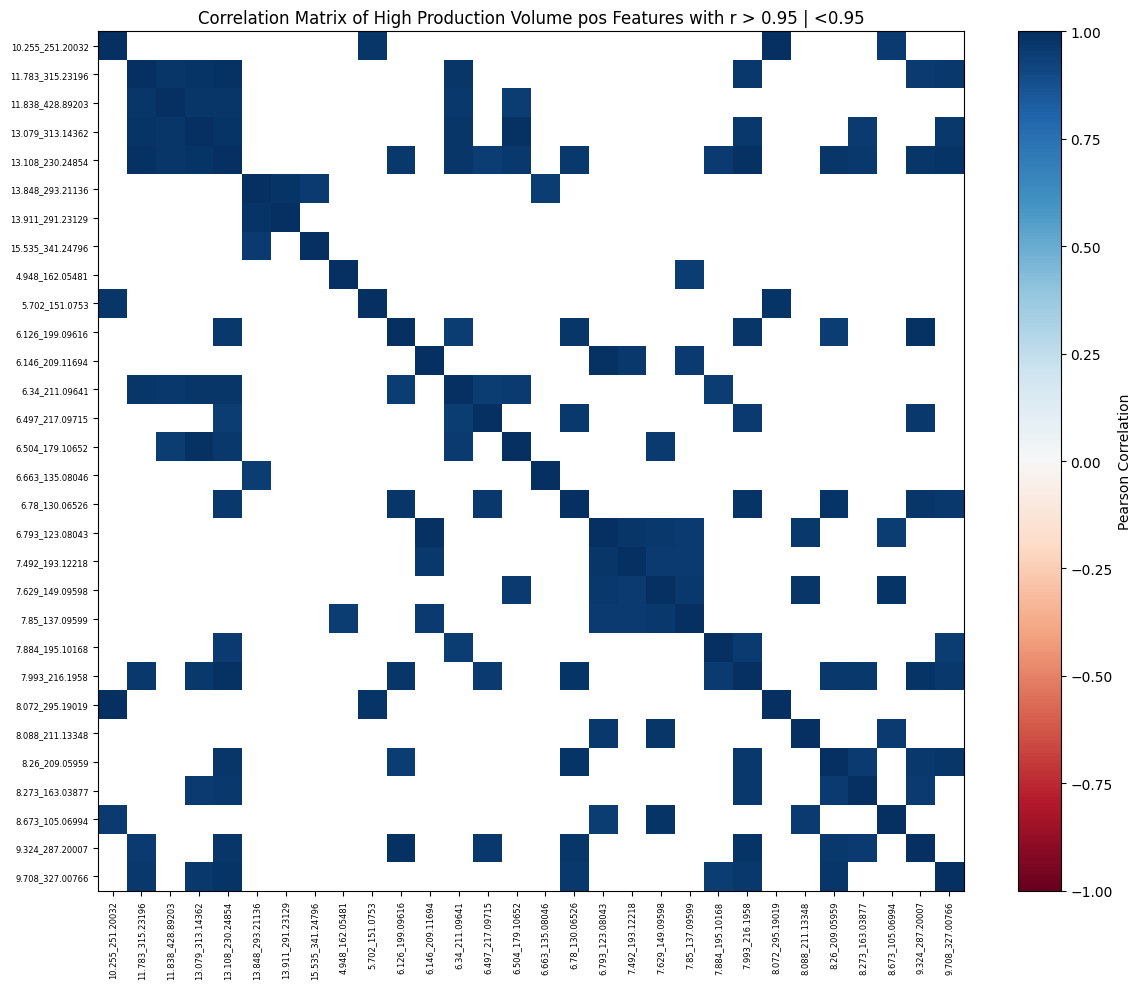

In [69]:
# 1) Get the set of features present in pos_corr_highPV
high_pv = np.unique(
    np.concatenate([pos_corr_highPV['feature_id'].values,
                    pos_corr_highPV['feature_id2'].values])
)

# 2) Pivot to square matrix
corr_mat = pos_corr_highPV.pivot(
    index='feature_id', columns='feature_id2', values='correlation'
)

# 3) Reindex to ensure full square and symmetry
corr_mat = corr_mat.reindex(index=high_pv, columns=high_pv)
corr_mat = corr_mat.fillna(corr_mat.T)
np.fill_diagonal(corr_mat.values, 1.0)

# 4) Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr_mat.values, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Pearson Correlation')
plt.xticks(np.arange(len(corr_mat)), corr_mat.columns, rotation=90, fontsize=6)
plt.yticks(np.arange(len(corr_mat)), corr_mat.index, fontsize=6)
plt.title('Correlation Matrix of High Production Volume pos Features with r > 0.95 | <0.95')
plt.tight_layout()
plt.show()

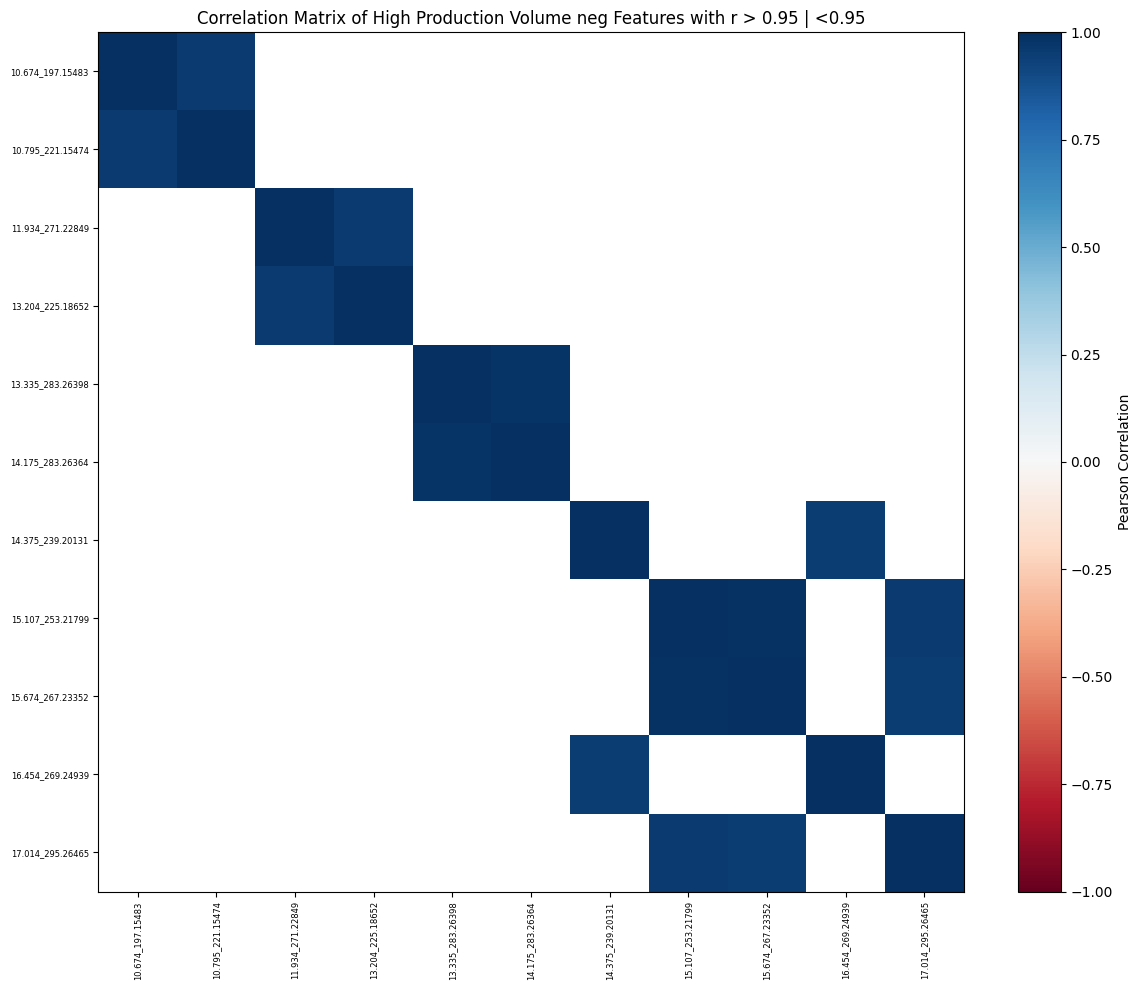

In [70]:
# 1) Get the set of features present in pos_corr_highPV
high_pv = np.unique(
    np.concatenate([neg_corr_highPV['feature_id'].values,
                    neg_corr_highPV['feature_id2'].values])
)

# 2) Pivot to square matrix
corr_mat = neg_corr_highPV.pivot(
    index='feature_id', columns='feature_id2', values='correlation'
)

# 3) Reindex to ensure full square and symmetry
corr_mat = corr_mat.reindex(index=high_pv, columns=high_pv)
corr_mat = corr_mat.fillna(corr_mat.T)
np.fill_diagonal(corr_mat.values, 1.0)

# 4) Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr_mat.values, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Pearson Correlation')
plt.xticks(np.arange(len(corr_mat)), corr_mat.columns, rotation=90, fontsize=6)
plt.yticks(np.arange(len(corr_mat)), corr_mat.index, fontsize=6)
plt.title('Correlation Matrix of High Production Volume neg Features with r > 0.95 | <0.95')
plt.tight_layout()
plt.show()

In [71]:
neg_corr_mulfunction = neg_corr[neg_corr['feature_id'].isin(level2copy[level2copy['Function_label'] == 'Multiple_Func']['feature_id'])]
neg_corr_unfunction = neg_corr[neg_corr['feature_id'].isin(level2copy[level2copy['Function_label'] == 'Unknown_Func']['feature_id'])]
neg_corr_plasticizer = neg_corr[neg_corr['feature_id'].isin(level2copy[level2copy['Function_label'] == 'Plasticizer']['feature_id'])]

pos_corr_mulfunction = pos_corr[pos_corr['feature_id'].isin(level2copy[level2copy['Function_label'] == 'Multiple_Func']['feature_id'])]
pos_corr_unfunction = pos_corr[pos_corr['feature_id'].isin(level2copy[level2copy['Function_label'] == 'Unknown_Func']['feature_id'])]
pos_corr_plasticizer = pos_corr[pos_corr['feature_id'].isin(level2copy[level2copy['Function_label'] == 'Plasticizer']['feature_id'])]

#print pos and neg mulfunction with correlation > 0.95 and < -0.95
neg_corr_mulfunction = neg_corr_mulfunction[(neg_corr_mulfunction['feature_id'] != neg_corr_mulfunction['feature_id2'])]
neg_corr_mulfunction = neg_corr_mulfunction[(neg_corr_mulfunction['correlation'] > 0.95) | (neg_corr_mulfunction['correlation'] < -0.95)]
neg_corr_mulfunction = neg_corr_mulfunction.drop_duplicates(subset=['feature_id', 'feature_id2'], keep='first')
neg_corr_mulfunction = neg_corr_mulfunction.sort_values(by='correlation', ascending=False)
neg_corr_mulfunction = neg_corr_mulfunction.reset_index(drop=True)

#positive correlation
pos_corr_mulfunction = pos_corr_mulfunction[(pos_corr_mulfunction['feature_id'] != pos_corr_mulfunction['feature_id2'])]
pos_corr_mulfunction = pos_corr_mulfunction[(pos_corr_mulfunction['correlation'] > 0.95) | (pos_corr_mulfunction['correlation'] < -0.95)]
pos_corr_mulfunction = pos_corr_mulfunction.drop_duplicates(subset=['feature_id', 'feature_id2'], keep='first')
pos_corr_mulfunction = pos_corr_mulfunction.sort_values(by='correlation', ascending=False)
pos_corr_mulfunction = pos_corr_mulfunction.reset_index(drop=True)

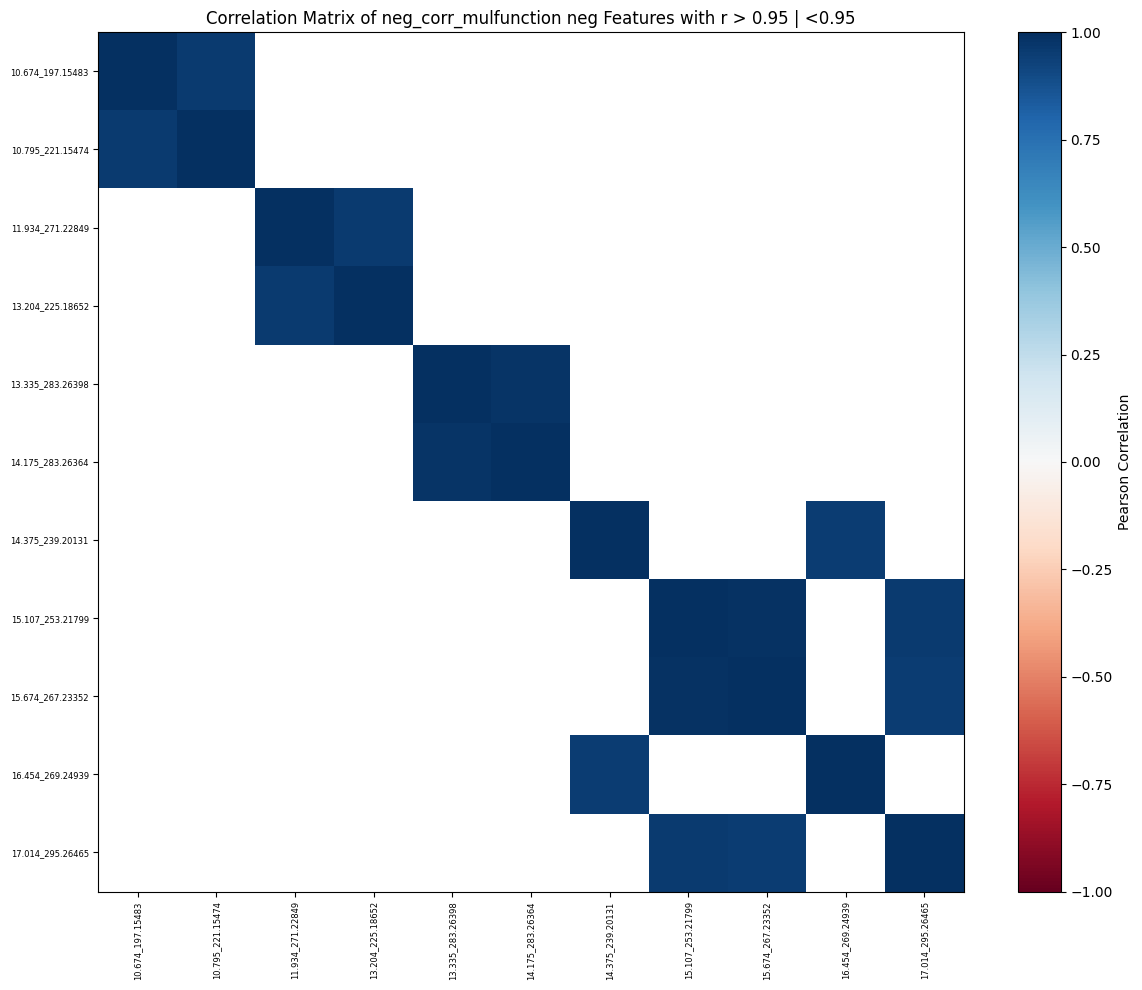

In [72]:
# 1) Get the set of features present in pos_corr_highPV
mul_func = np.unique(
    np.concatenate([neg_corr_mulfunction['feature_id'].values,
                    neg_corr_mulfunction['feature_id2'].values])
)

# 2) Pivot to square matrix
corr_mat = neg_corr_mulfunction.pivot(
    index='feature_id', columns='feature_id2', values='correlation'
)

# 3) Reindex to ensure full square and symmetry
corr_mat = corr_mat.reindex(index=mul_func, columns=mul_func)
corr_mat = corr_mat.fillna(corr_mat.T)
np.fill_diagonal(corr_mat.values, 1.0)

# 4) Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr_mat.values, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Pearson Correlation')
plt.xticks(np.arange(len(corr_mat)), corr_mat.columns, rotation=90, fontsize=6)
plt.yticks(np.arange(len(corr_mat)), corr_mat.index, fontsize=6)
plt.title('Correlation Matrix of neg_corr_mulfunction neg Features with r > 0.95 | <0.95')
plt.tight_layout()
plt.show()

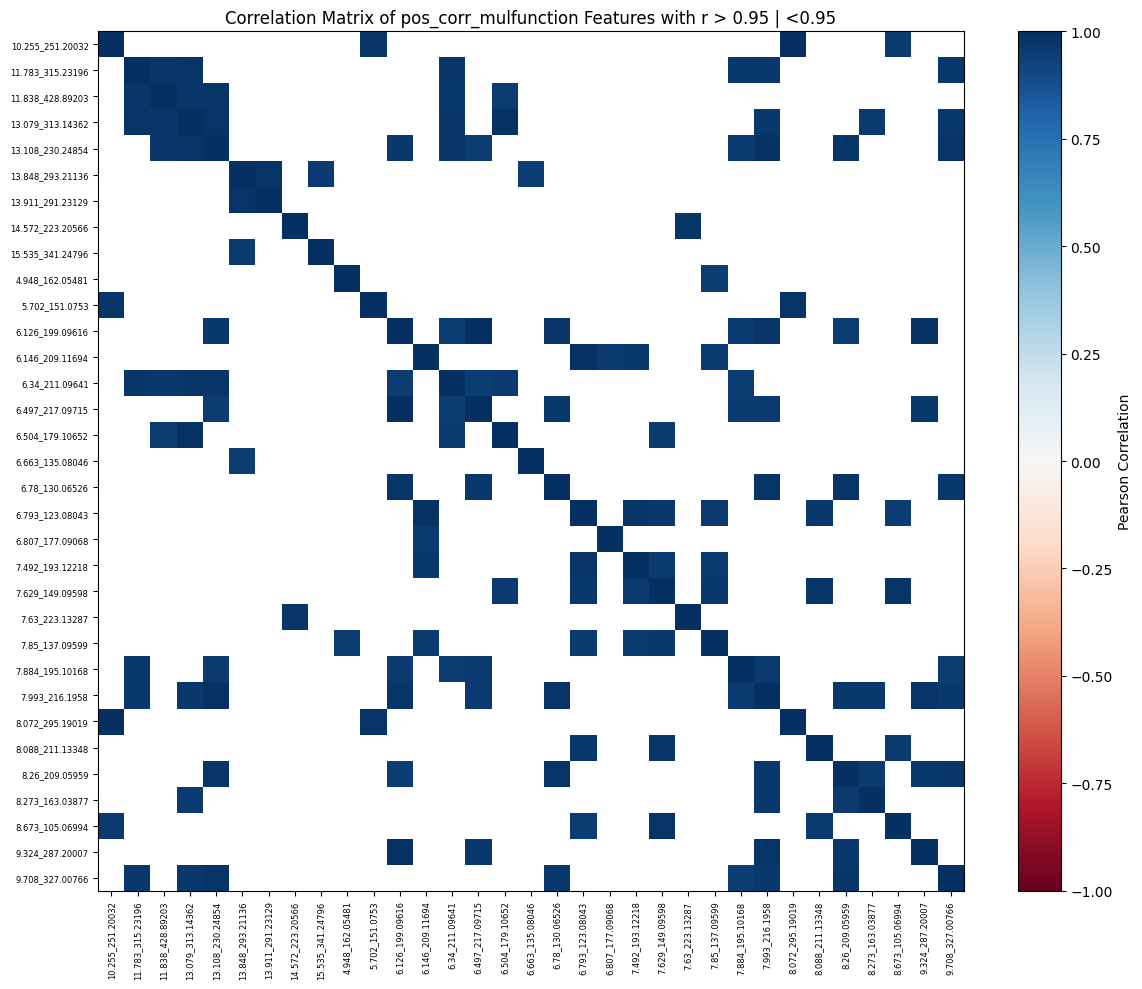

In [73]:
# 1) Get the set of features present in pos_corr_highPV
mul_func = np.unique(
    np.concatenate([pos_corr_mulfunction['feature_id'].values,
                    pos_corr_mulfunction['feature_id2'].values])
)

# 2) Pivot to square matrix
corr_mat = pos_corr_mulfunction.pivot(
    index='feature_id', columns='feature_id2', values='correlation'
)

# 3) Reindex to ensure full square and symmetry
corr_mat = corr_mat.reindex(index=mul_func, columns=mul_func)
corr_mat = corr_mat.fillna(corr_mat.T)
np.fill_diagonal(corr_mat.values, 1.0)

# 4) Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr_mat.values, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Pearson Correlation')
plt.xticks(np.arange(len(corr_mat)), corr_mat.columns, rotation=90, fontsize=6)
plt.yticks(np.arange(len(corr_mat)), corr_mat.index, fontsize=6)
plt.title('Correlation Matrix of pos_corr_mulfunction Features with r > 0.95 | <0.95')
plt.tight_layout()
plt.show()

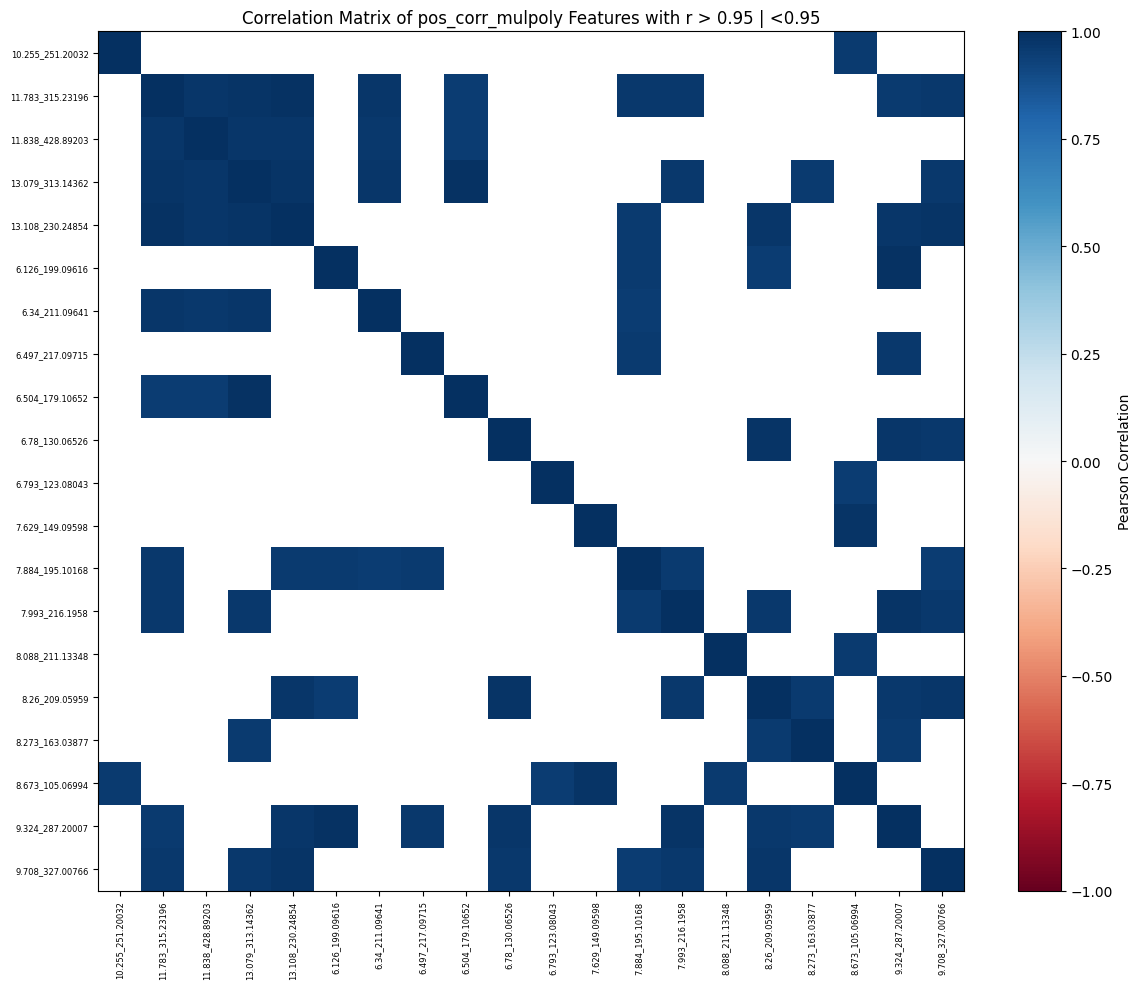

In [74]:
neg_corr_mulpoly = neg_corr[neg_corr['feature_id'].isin(level2copy[level2copy['Polymer_label'] == 'Mltiple_Poly']['feature_id'])]
neg_corr_unpoly = neg_corr[neg_corr['feature_id'].isin(level2copy[level2copy['Polymer_label'] == 'Unknown_Poly']['feature_id'])]
pos_corr_mulpoly = pos_corr[pos_corr['feature_id'].isin(level2copy[level2copy['Polymer_label'] == 'Mltiple_Poly']['feature_id'])]
pos_corr_unpoly = pos_corr[pos_corr['feature_id'].isin(level2copy[level2copy['Polymer_label'] == 'Unknown_Poly']['feature_id'])]

#print pos and neg highPV with correlation > 0.95 and < -0.95
#remove rows with identical feature_id and feature_id2, when feature_id == feature_id2
neg_corr_mulpoly = neg_corr_mulpoly[(neg_corr_mulpoly['feature_id'] != neg_corr_mulpoly['feature_id2'])]
pos_corr_mulpoly = pos_corr_mulpoly[(pos_corr_mulpoly['feature_id'] != pos_corr_mulpoly['feature_id2'])]
neg_corr_mulpoly = neg_corr_mulpoly[(neg_corr_mulpoly['correlation'] > 0.95) | (neg_corr_mulpoly['correlation'] < -0.95)]
neg_corr_mulpoly = neg_corr_mulpoly.drop_duplicates(subset=['feature_id', 'feature_id2'], keep='first')
neg_corr_mulpoly = neg_corr_mulpoly.sort_values(by='correlation', ascending=False)
neg_corr_mulpoly = neg_corr_mulpoly.reset_index(drop=True)

#positive correlation
pos_corr_mulpoly = pos_corr_mulpoly[(pos_corr_mulpoly['correlation'] > 0.95) | (pos_corr_mulpoly['correlation'] < -0.95)]
pos_corr_mulpoly = pos_corr_mulpoly.drop_duplicates(subset=['feature_id', 'feature_id2'], keep='first')
pos_corr_mulpoly = pos_corr_mulpoly.sort_values(by='correlation', ascending=False)
pos_corr_mulpoly = pos_corr_mulpoly.reset_index(drop=True)

#remove rows with identical feature_id and feature_id2, when feature_id == feature_id2

# 1) Get the set of features present in pos_corr_highPV
mulpoly = np.unique(
    np.concatenate([pos_corr_mulpoly['feature_id'].values,
                    pos_corr_mulpoly['feature_id2'].values])
)

# 2) Pivot to square matrix
corr_mat = pos_corr_mulpoly.pivot(
    index='feature_id', columns='feature_id2', values='correlation'
)

# 3) Reindex to ensure full square and symmetry
corr_mat = corr_mat.reindex(index=mulpoly, columns=mulpoly)
corr_mat = corr_mat.fillna(corr_mat.T)
np.fill_diagonal(corr_mat.values, 1.0)

# 4) Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr_mat.values, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Pearson Correlation')
plt.xticks(np.arange(len(corr_mat)), corr_mat.columns, rotation=90, fontsize=6)
plt.yticks(np.arange(len(corr_mat)), corr_mat.index, fontsize=6)
plt.title('Correlation Matrix of pos_corr_mulpoly Features with r > 0.95 | <0.95')
plt.tight_layout()
plt.show()

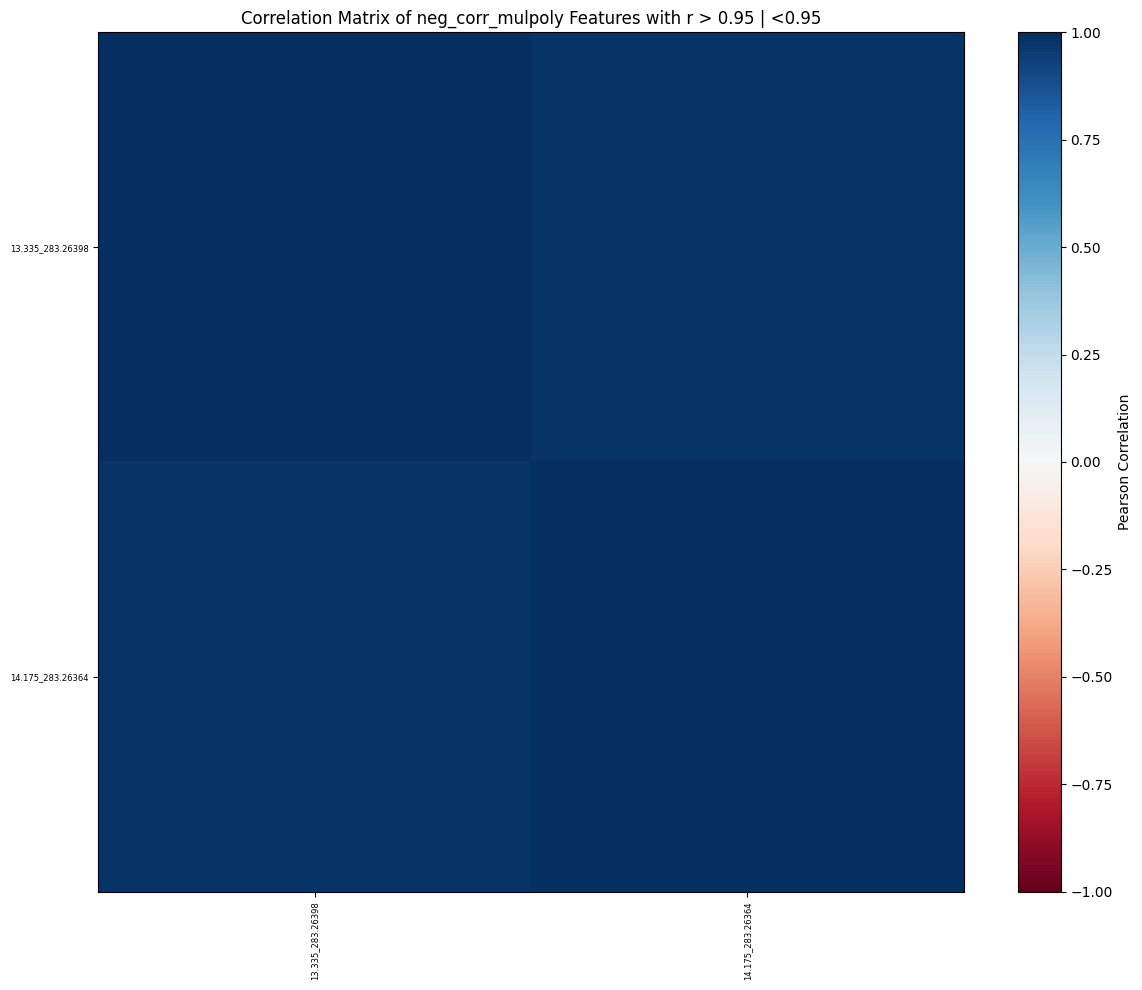

In [75]:
# 1) Get the set of features present in pos_corr_highPV
mulpoly = np.unique(
    np.concatenate([neg_corr_mulpoly['feature_id'].values,
                    neg_corr_mulpoly['feature_id2'].values])
)

# 2) Pivot to square matrix
corr_mat = neg_corr_mulpoly.pivot(
    index='feature_id', columns='feature_id2', values='correlation'
)

# 3) Reindex to ensure full square and symmetry
corr_mat = corr_mat.reindex(index=mulpoly, columns=mulpoly)
corr_mat = corr_mat.fillna(corr_mat.T)
np.fill_diagonal(corr_mat.values, 1.0)

# 4) Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr_mat.values, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Pearson Correlation')
plt.xticks(np.arange(len(corr_mat)), corr_mat.columns, rotation=90, fontsize=6)
plt.yticks(np.arange(len(corr_mat)), corr_mat.index, fontsize=6)
plt.title('Correlation Matrix of neg_corr_mulpoly Features with r > 0.95 | <0.95')
plt.tight_layout()
plt.show()

In [76]:
neg_corr_benzenoids = neg_corr[neg_corr['feature_id'].isin(level2copy[level2copy['Superclass'] == 'benzenoids']['feature_id'])]
neg_corr_lipidlike = neg_corr[neg_corr['feature_id'].isin(level2copy[level2copy['Superclass'] == 'lipid-like mols']['feature_id'])]
neg_corr_organic_acids = neg_corr[neg_corr['feature_id'].isin(level2copy[level2copy['Superclass'] == 'organic acids and derivatives']['feature_id'])]

pos_corr_benzenoids = pos_corr[pos_corr['feature_id'].isin(level2copy[level2copy['Superclass'] == 'benzenoids']['feature_id'])]
pos_corr_lipidlike = pos_corr[pos_corr['feature_id'].isin(level2copy[level2copy['Superclass'] == 'lipid-like mols']['feature_id'])]
pos_corr_organic_acids = pos_corr[pos_corr['feature_id'].isin(level2copy[level2copy['Superclass'] == 'organic acids and derivatives']['feature_id'])]

#print pos and neg highPV with correlation > 0.95 and < -0.95
#remove rows with identical feature_id and feature_id2, when feature_id == feature_id2
neg_corr_benzenoids = neg_corr_benzenoids[(neg_corr_benzenoids['feature_id'] != neg_corr_benzenoids['feature_id2'])]

neg_corr_benzenoids = neg_corr_benzenoids[(neg_corr_benzenoids['correlation'] > 0.95) | (neg_corr_benzenoids['correlation'] < -0.95)]
neg_corr_benzenoids = neg_corr_benzenoids.drop_duplicates(subset=['feature_id', 'feature_id2'], keep='first')
neg_corr_benzenoids = neg_corr_benzenoids.sort_values(by='correlation', ascending=False)
neg_corr_benzenoids = neg_corr_benzenoids.reset_index(drop=True)

#positive correlation
pos_corr_benzenoids = pos_corr_benzenoids[(pos_corr_benzenoids['feature_id'] != pos_corr_benzenoids['feature_id2'])]
pos_corr_benzenoids = pos_corr_benzenoids[(pos_corr_benzenoids['correlation'] > 0.95) | (pos_corr_benzenoids['correlation'] < -0.95)]
pos_corr_benzenoids = pos_corr_benzenoids.drop_duplicates(subset=['feature_id', 'feature_id2'], keep='first')
pos_corr_benzenoids = pos_corr_benzenoids.sort_values(by='correlation', ascending=False)
pos_corr_benzenoids = pos_corr_benzenoids.reset_index(drop=True)


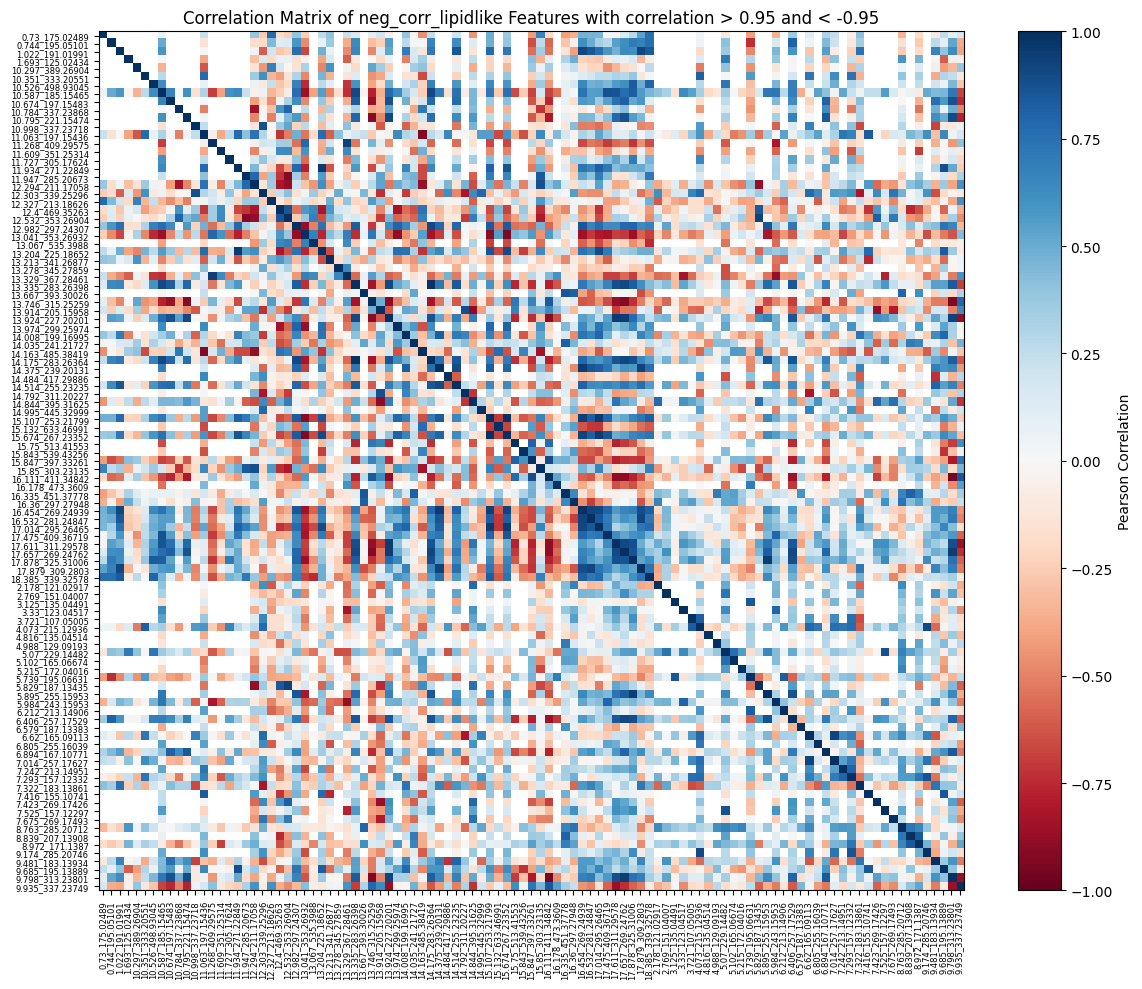

In [77]:
# 1) Get the set of features present in pos_corr_highPV
lipidlike = np.unique(
    np.concatenate([neg_corr_lipidlike['feature_id'].values,
                    neg_corr_lipidlike['feature_id2'].values])
)

# 2) Pivot to square matrix
corr_mat = neg_corr_lipidlike.pivot(
    index='feature_id', columns='feature_id2', values='correlation'
)

# 3) Reindex to ensure full square and symmetry
corr_mat = corr_mat.reindex(index=lipidlike, columns=lipidlike)
corr_mat = corr_mat.fillna(corr_mat.T)
np.fill_diagonal(corr_mat.values, 1.0)

# 4) Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr_mat.values, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Pearson Correlation')
plt.xticks(np.arange(len(corr_mat)), corr_mat.columns, rotation=90, fontsize=6)
plt.yticks(np.arange(len(corr_mat)), corr_mat.index, fontsize=6)
plt.title('Correlation Matrix of neg_corr_lipidlike Features with correlation > 0.95 and < -0.95')
plt.tight_layout()
plt.show()

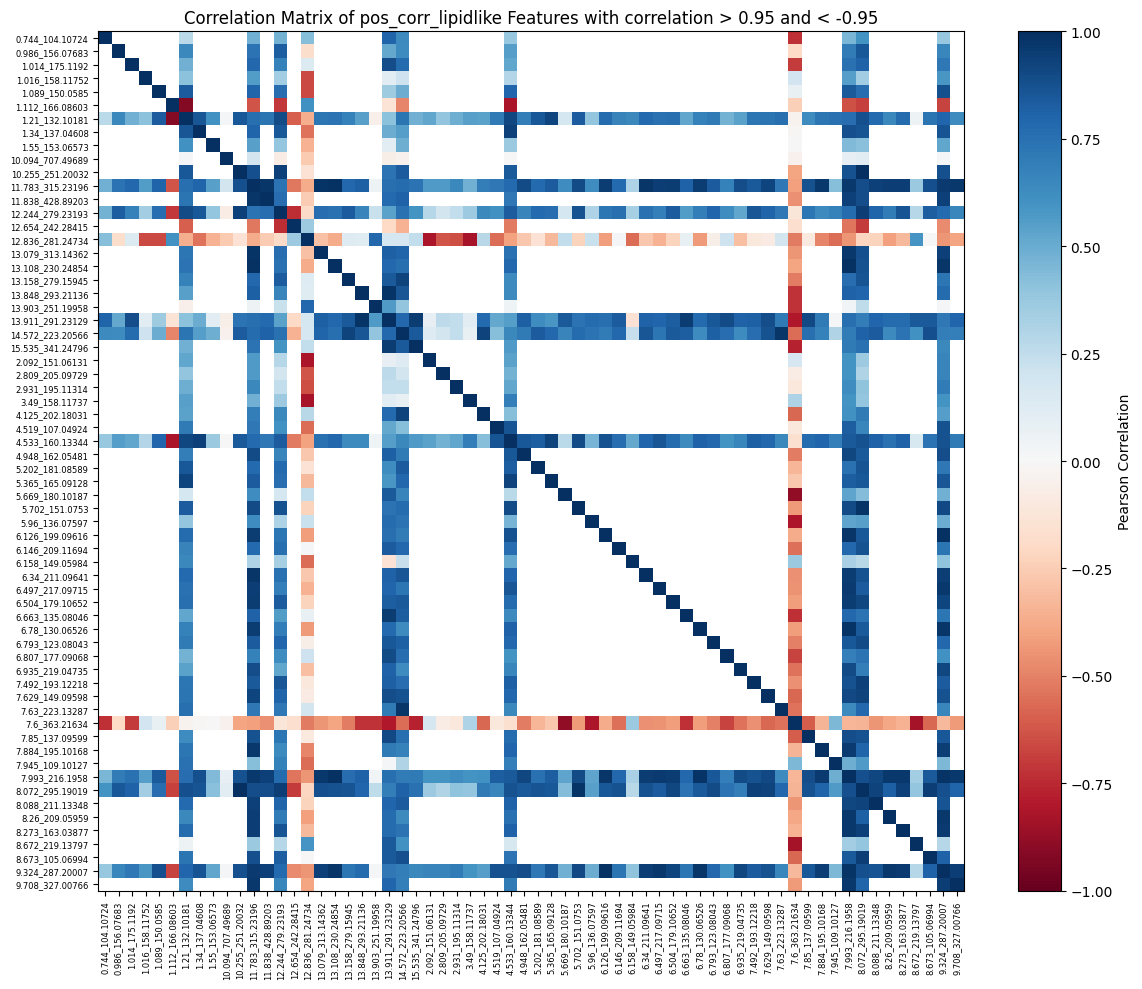

In [78]:
# 1) Get the set of features present in pos_corr_highPV
lipidlike = np.unique(
    np.concatenate([pos_corr_lipidlike['feature_id'].values,
                    pos_corr_lipidlike['feature_id2'].values])
)

# 2) Pivot to square matrix
corr_mat = pos_corr_lipidlike.pivot(
    index='feature_id', columns='feature_id2', values='correlation'
)

# 3) Reindex to ensure full square and symmetry
corr_mat = corr_mat.reindex(index=lipidlike, columns=lipidlike)
corr_mat = corr_mat.fillna(corr_mat.T)
np.fill_diagonal(corr_mat.values, 1.0)

# 4) Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr_mat.values, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Pearson Correlation')
plt.xticks(np.arange(len(corr_mat)), corr_mat.columns, rotation=90, fontsize=6)
plt.yticks(np.arange(len(corr_mat)), corr_mat.index, fontsize=6)
plt.title('Correlation Matrix of pos_corr_lipidlike Features with correlation > 0.95 and < -0.95')
plt.tight_layout()
plt.show()

In [92]:
level1 = level2copy[(level2copy['annotation_level'] == '1')]
# print(tabulate.tabulate(level1, headers='keys', tablefmt='psql'))
level1_feat = level1['feature_id']

In [93]:
#get level1 abundance bade on feature_id 
neg_peak_area = 'D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/Neg_PCA_batchcorrected_data.csv'  #feature id with duplicated peak abundance data 
pos_peak_area = 'D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Pos_AlignmentResults/Pos_PCA_batchcorrected_data.csv'  #feature id with duplicated peak abundance data
neg_peak_area = pd.read_csv(neg_peak_area)
pos_peak_area = pd.read_csv(pos_peak_area)

#extract the corrected peak area data for pos and neg polarity based on the feature_id
pos_peak_area_level = pos_peak_area[pos_peak_area['feature_id'].isin(level1_feat)]
neg_peak_area_level = neg_peak_area[neg_peak_area['feature_id'].isin(level1_feat)]

#merge PREFFERED_NAME and DTXSID from level1 to combined_df
pos_combined = pd.merge(pos_peak_area_level, level1[['feature_id', 'PREFERRED_NAME']], how='left', left_on='feature_id', right_on='feature_id')
neg_combined = pd.merge(neg_peak_area_level, level1[['feature_id', 'PREFERRED_NAME']], how='left', left_on='feature_id', right_on='feature_id')

#
print(tabulate.tabulate(pos_combined, headers='keys', tablefmt='psql'))
print(tabulate.tabulate(neg_combined, headers='keys', tablefmt='psql'))

+----+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------

C:\Users\yangj\AppData\Local\Temp\ipykernel_45132\4198923234.py:9: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\yangj\AppData\Local\Temp\ipykernel_45132\4198923234.py:16: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



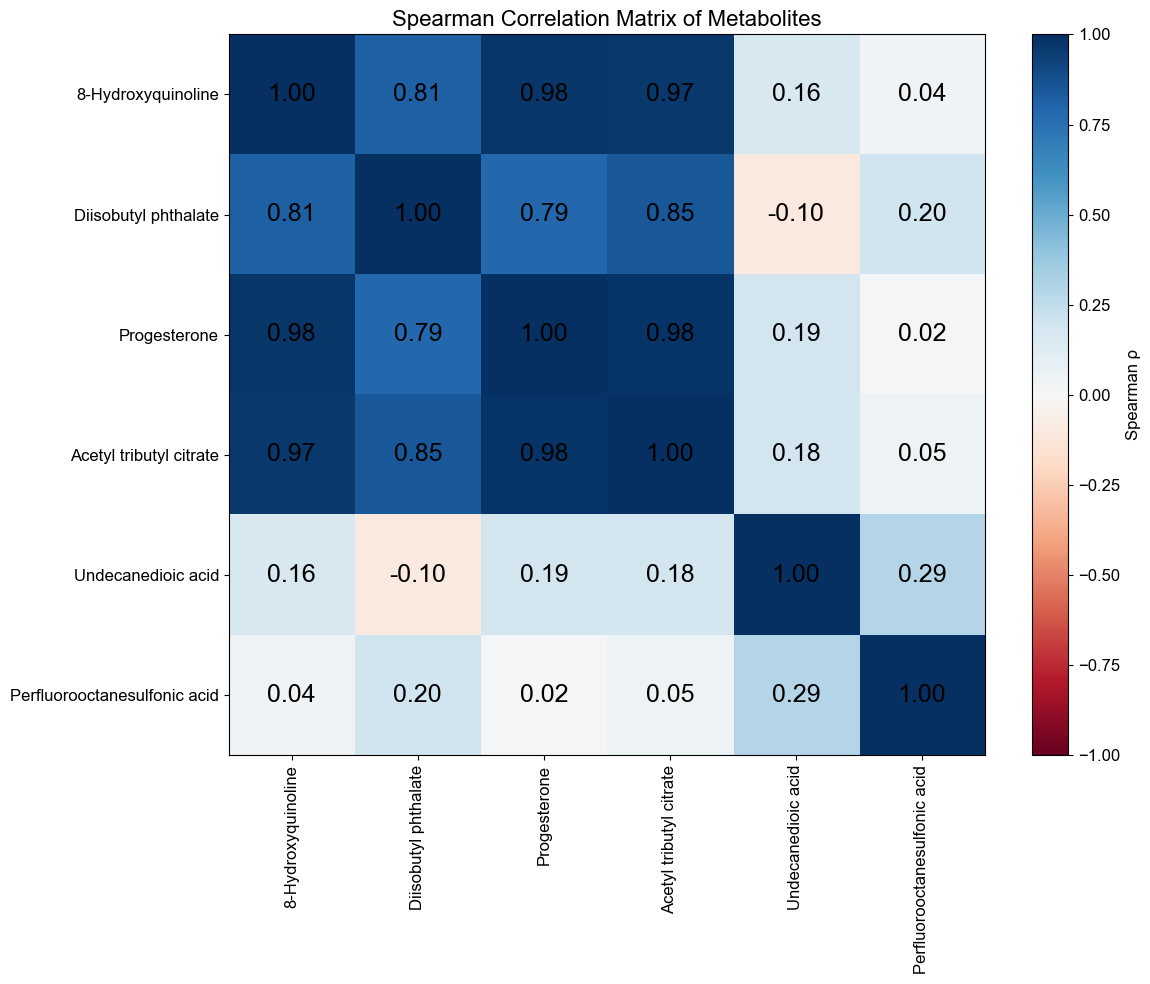

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

pos_data = pos_combined.copy()
clean_names = pos_data.columns.str.extract(r'BH(\d{5})')[0]
pos_data.columns = clean_names
pos_data = pos_data.apply(pd.to_numeric, errors='coerce')
# Average replicates
pos_avg = pos_data.groupby(level=0, axis=1).mean()

neg_data = neg_combined.copy()
clean_names = neg_data.columns.str.extract(r'BH(\d{5})')[0]
neg_data.columns = clean_names
neg_data = neg_data.apply(pd.to_numeric, errors='coerce')
# Average replicates
neg_avg = neg_data.groupby(level=0, axis=1).mean()

#add PREFERRED_NAME  to to pos_avg and neg_avg 
pos_avg['PREFERRED_NAME'] = pos_combined['PREFERRED_NAME']
neg_avg['PREFERRED_NAME'] = neg_combined['PREFERRED_NAME']

#combined pos and neg by row
combined_df = pd.concat([pos_avg, neg_avg], axis=0, ignore_index=True)
combined_df = combined_df.reset_index()

#make correlation matrix for rows in combined_df and make the correlation matrix plot, use the PREFERRED_NAME as the index  
combined_df = combined_df.set_index('PREFERRED_NAME')
combined_df = combined_df.T
combined_df = combined_df.apply(pd.to_numeric, errors='coerce')
combined_df_corr = combined_df.corr(method='spearman')


# --- 5. Plot correlation matrix ---
# Set font globally to Arial 12pt
# plt.rc('font', family='Arial', size=18)

# fig, ax = plt.subplots(figsize=(12, 10))
# # Use a diverging colormap mapping -1→red, +1→blue
# cax = ax.imshow(combined_df_corr.values, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)

# cbar = fig.colorbar(cax, ax=ax)
# cbar.set_label('Spearman ρ')

# labels = combined_df_corr.columns.tolist()
# ax.set_xticks(range(len(labels)))
# ax.set_xticklabels(labels, rotation=90)
# ax.set_yticks(range(len(labels)))
# ax.set_yticklabels(labels)

# ax.set_title('Spearman Correlation Matrix of Metabolites')
# fig.tight_layout()

# # Save as high-resolution TIFF
# fig.savefig('D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/spearman_correlation_matrix.tiff', format='tiff', dpi=300)

# plt.show()


# 1) Set global font to Arial 12 pt
plt.rc('font', family='Arial', size=12)

# 2) Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# 3) Plot the matrix with a red↔blue diverging scale (-1→red, +1→blue)
cax = ax.imshow(
    combined_df_corr.values,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    aspect='auto'
)

# 4) Add and label the colorbar
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Spearman ρ', fontname='Arial', fontsize=12)

# 5) Tick labels
labels = combined_df_corr.columns.tolist()
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, fontname='Arial', fontsize=12)
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, fontname='Arial', fontsize=12)

# 6) Annotate correlation coefficients in each cell
for i in range(len(labels)):
    for j in range(len(labels)):
        val = combined_df_corr.iat[i, j]
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black', fontname='Arial', fontsize=18)

# 6) Title
ax.set_title('Spearman Correlation Matrix of Metabolites', fontname='Arial', fontsize=16)

# 7) Layout and save
fig.tight_layout()
fig.savefig('D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/spearman_correlation_matrix.tiff', format='tiff', dpi=300)
plt.show(fig)
plt.close(fig)